## SIR-X model


The SIR-X model http://rocs.hu-berlin.de/corona/docs/forecast/results_by_country/ is a simple but seems to be accurate model.

The population is described by **S** (fraction of people suspectible to the infection), **I** (fraction of people infected and spreading the infection), (**R** which is neither suspectible nor infected), and **X** (the number of "quarantineed" people). 

$X$ is roughly the number of cases reported by each country. 

The equations describing the evolution of $S$, $I$, $R$ and $X$ are self-explanatory:

$$\frac{dS}{dt} = -\alpha S I - k_0 S,  \quad \frac{dI}{dt} = \alpha S I - \beta I - k_0 I - k I, 
\quad \frac{dX}{dt} = (k_0 + k) I, \quad \frac{dR}{dt} = k_0 S + \beta I.$$

The first equation controls the spread of the infection (the growth is proportional to the probability of meeting of $S$ and $I$), 
the constant $\beta$ controls the recovery / death process (and is roughly $\beta \approx \frac{1}{T}$, where $T$ is the characteristic time of the decease). 

The parameters $k_0$ and $k$ represent the measures taken: $k_0$ corresponds to social distancing / contract tracing, whereas $k$ controls the quarantine process for symptomatic individuals

To fit the model, one has to find the parameters of it $\alpha, \beta, k_0, k$ and the initial number of infected individuals $I_0$ such that the $X(t)$ approximates the observed cases $C(t)$. The true number of potentially infected people $I(t)$ can be much larger. 

Several optimization techniques can be used. We tried gradient-free optimization package **nevergrad**, however, 
right now we are doing the Bayesian optimization in order to give not only the values of parameters, but also the risk values. 


The data collection below is taken form a nice [Google Colab notebook](https://colab.research.google.com/drive/15R6bXKW--TSMXClMfHql8zU0ePOLEoa3)

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
#import pymc as pm
from scipy.integrate import odeint
from concurrent import futures

%matplotlib inline


In [475]:
online = True

if online:
    COVID_CONFIRMED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
else:
    COVID_CONFIRMED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    


covid_confirmed = pd.read_csv(COVID_CONFIRMED_URL)
covid_deaths = pd.read_csv(COVID_DEATHS_URL)
covid_recovered = pd.read_csv(COVID_RECOVERED_URL)

covid_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_confirmed.rename(columns={'Province/State':'State'}, inplace=True)
covid_deaths.rename(columns={'Province/State':'State'}, inplace=True)
covid_recovered.rename(columns={'Province/State':'State'}, inplace=True)


covid_confirmed.sort_values(covid_confirmed.columns[-1]).tail()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
116,NaN,France,46.2276,2.2137,0,0,2,3,3,3,...,52128,56989,59105,64338,89953,92839,98010,109069,112950,117749
120,NaN,Germany,51.0000,9.0000,0,0,0,0,0,1,...,71808,77872,84794,91159,96092,100123,103374,107663,113296,118181
137,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,105792,110574,115242,119827,124632,128948,132547,135586,139422,143626
201,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,...,95923,104118,112065,119199,126168,131646,136675,141942,148220,153222
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,188172,213372,243762,275586,308853,337072,366667,396223,429052,461437


In [476]:
Country = 'Russia'
population = {"Russia" : 146745098, "Italy" : 60317000, "China" : 1404328000}

data_country_confirmed = covid_confirmed[covid_confirmed.Country == Country].values[0, 4:].astype(int)

data = np.empty((3, data_country_confirmed.shape[0]), dtype=np.int64)
data[0] = data_country_confirmed

data[1] = covid_deaths   [covid_deaths.Country    == Country].values[0, 4:].astype(int)
data[2] = covid_recovered[covid_recovered.Country == Country].values[0, 4:].astype(int)

data_normed = data.astype(np.float64) / population[Country]
data_normed_only_conf = data_normed[0] - data_normed[1] - data_normed[2]

data[0][-1]

10131

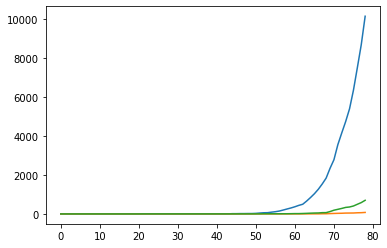

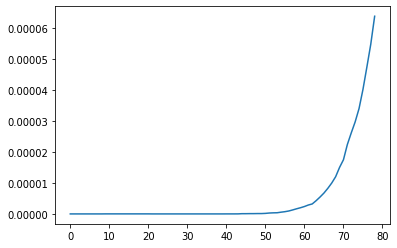

In [477]:
plt.plot(data.T);
plt.figure()
plt.plot(data_normed_only_conf);

In [159]:
@jit
def base_seir_model(init_vals, dt, N, params):
    res = np.empty((N, 4), dtype=np.float64)
    S = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    #print(I)
    return res


def seir_rhs(y, t, alpha, beta, gamma):
    S, E, I, R = y
    return [-beta*S*I, beta*S*I - alpha*E, alpha*E - gamma*I, gamma*I]

def base_seir_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N + 1)
    sol = odeint(seir_rhs, init_vals, t, args=params)
    #return sol[::int(1/dt)]
    return sol

@jit
def sirx_rhs(x, t, alpha, beta, k0, k):
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = (alpha*S - beta - (k0 + k))*I
    dxdt = (k0 + k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])


def base_sirx_model_rhs(x, params):
    alpha, beta, k0, k = params
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = alpha*S*I - beta*I - k0*I - k*I
    dxdt = (k0+k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])

#@jit
def base_sirx_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N + 1)
    sol = odeint(sirx_rhs, init_vals, t, args=params)
    #sol[np.isnan(sol)] = 1e20
    #sol[np.isinf(sol)] = 1e20
    return sol



# SIR Model (not working)
@jit
def base_sirf_model(init_vals, dt, N, params):
    res = np.empty((N, 3), dtype=np.float64)
    y = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    return res


In [492]:
#vals = []

data1 = data[0]
data1 = data1[data1>=3]
# data1 = data1/population[Country]
#plt.plot(data1)

#true_cases = data_normed_only_conf[-20:]
#true_cases = data_normed_only_conf[data[0] >= 3]
#true_cases = data_normed[0][data[0] >= 3]
true_cases = data1/population[Country]


def obs(alpha_MC, beta_MC, k0_MC, k_MC, I0_MC, cf = 1, N = len(true_cases), type_ret=2):
        # N is number of points (days)
        #global vals
        dt = 1.0/cf
        num = (N-1)*cf
        # res = base_sirx_model_odeint((1.0 - (I0_MC + true_cases[0]), I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        res = base_sirx_model_odeint((1.0 - I0_MC, I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        rr = res.T[type_ret][::cf]
        #print(rr)
        #vals.append(rr)
        return rr
    
def obs2(alpha_MC, beta_MC, k0_MC, k_MC, I0_MC, cf = 1, N = len(true_cases)):
        # N is number of points (days)
        #global vals
        dt = 1.0/cf
        num = (N-1)*cf
        # res = base_sirx_model_odeint((1.0 - (I0_MC + true_cases[0]), I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        res = base_sirx_model_odeint((1.0 - I0_MC, I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        rr = res.T[::cf]
        #print(rr)
        #vals.append(rr)
        return rr

    
data_offset = 15
def loss_fn_weighted(alpha, beta, k0, k, I0):
    # Weighted variance
    loss_val = np.linalg.norm( (obs(alpha, beta, k0, k, I0)[data_offset:] - true_cases[data_offset:])*data1[data_offset:] )
    return loss_val

def loss_fn_equal_weight(alpha, beta, k0, k, I0):
    # Equal weight variance
    loss_val = np.linalg.norm(obs(alpha, beta, k0, k, I0)[data_offset:] - true_cases[data_offset:])
    return loss_val

_ = """
num_days = len(true_cases)-1
times = np.linspace(0, num_days, num_days+1)

def compute_fit(alpha, beta, k0, k, I0):
    params = np.array([alpha, beta, k0, k])
    x0 = np.array([1.0, I0, true_cases[0], 0.0])
    rhs = lambda x, t: base_sirx_model_rhs(x, params)
    sol = odeint(rhs, x0, times)
    predicted_cases = sol[:, 2]
    return np.linalg.norm(true_cases-predicted_cases)


def predict(alpha, beta, I0, k0, k, num_days):
    times = np.linspace(0, num_days, num_days+1)
    params = np.array([alpha, beta, k0, k])
    x0 = np.array([1.0, I0, true_cases[0], 0.0])
    rhs = lambda x, t: base_sirx_model_rhs(x, params)
    sol = odeint(rhs, x0, times)
    return sol

"""

In [508]:
def show_match(vals, new_figure=True, label='Predicted'):
    alpha_g, beta_g, k0_g, k_g, I0_g = vals
    num = len(true_cases)+3
    solution = population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=num, cf=1)

    time_scale = np.linspace(1, num, num)
    time_scale_true = np.linspace(1, len(true_cases), len(true_cases))
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.legend();
        plt.title('Match between predicted and actual cases');
        plt.plot(time_scale_true, population[Country]*true_cases, "o", label="true");
    plt.plot(time_scale, solution, "-", label=label);
    # plt.yscale('log')
    for i in (3,2,1):
        print("{}: day {}: number of cases:{:.0f}".format(label, 4-i, solution[-i] - solution[-i-1]))
        
def present_solution_many(vals, num_days=120, new_figure=True, label_prefix=None):
    alpha_g, beta_g, k0_g, k_g, I0_g = vals
    solution = population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=num_days, cf=1)
    # print(f"{label}: Max cases: {max(solution):.0f}")
    if label_prefix is None:
        label_prefix = ""

    cases_max = solution[-1]/1000
    label = label_prefix + f"{cases_max:6.1f}"
    time_scale = np.linspace(-len(true_cases)+1, num_days - len(true_cases), num_days)
    time_scale_true = np.linspace(-len(true_cases)+1 , -1, len(true_cases))
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.legend();
        plt.title('reported cases');
        plt.plot(time_scale_true, population[Country]*true_cases, "o", label="true");
    plt.plot(time_scale, solution, "-", label=label);
    plt.text(time_scale[-10], solution[-1], label)
    # plt.yscale('log')

def present_solution(vals, num_days=120, new_figure=True, label="Predicted"):
    alpha_g, beta_g, k0_g, k_g, I0_g = vals
    solution = population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=num_days, cf=1)
    print(f"{label}: Max cases: {max(solution):.0f}")

    time_scale = np.linspace(-len(true_cases)+1, num_days - len(true_cases), num_days)
    time_scale_true = np.linspace(-len(true_cases)+1 , -1, len(true_cases))
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.legend();
        plt.title('reported cases');
        plt.plot(time_scale_true, population[Country]*true_cases, "o", label="true");
    plt.plot(time_scale, solution, "-", label=label);
    plt.text(time_scale[-10], solution[-1], label)
    # plt.yscale('log')


def prognosis(vals, num_days = 120, new_figure=True, several_scenarios=True, label_prefix=None):
    alpha_g, beta_g, k0_g, k_g, I0_g = vals
    start = obs2(alpha_g, beta_g, k0_g, k_g, I0_g, N=len(true_cases))[:, -1]
    dt = 1.0
    res1 = base_sirx_model_odeint(start, dt, num_days, (alpha_g, beta_g, k0_g, k_g))
    if several_scenarios:
        res2 = base_sirx_model_odeint(start, dt, num_days, (alpha_g, beta_g, 1e-2, k_g))
        res3 = base_sirx_model_odeint(start, dt, num_days, (alpha_g, beta_g, 1e-1, k_g))
    
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.title('Potentially infected')
        plt.legend()
    if label_prefix is not None: 
        label_prefix += ": "
    else:
        label_prefix = ''
    plt.plot(res1[:, 1]*population[Country], label=f'{label_prefix}Current measures')
    if several_scenarios:
        plt.plot(res2[:, 1]*population[Country], label=f'{label_prefix}1% strictly isolated')
        plt.plot(res3[:, 1]*population[Country], label=f'{label_prefix}10% strictly isolated')
    print(f"{label_prefix}Infected now: {res1[0, 1]*population[Country]:.0f}")
    if several_scenarios:
        print(f"{label_prefix}Max infected: {max(res1[:, 1]*population[Country]):.0f} vs {max(res2[:, 1]*population[Country]):.0f} vs {max(res3[:, 1]*population[Country]):.0f}")
    else:
        print(f"{label_prefix}Max infected: {max(res1[:, 1]*population[Country]):.0f}")

def prognosis_many(vals, num_days = 120, label_prefix=None, new_figure=True):
    alpha_g, beta_g, k0_g, k_g, I0_g = vals
    start = obs2(alpha_g, beta_g, k0_g, k_g, I0_g, N=len(true_cases))[:, -1]
    dt = 1.0
    res1 = base_sirx_model_odeint(start, dt, num_days, (alpha_g, beta_g, k0_g, k_g))
    
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.title('Potentially infected')
        plt.legend()
    if label_prefix is not None: 
        label_prefix += ": "
    else:
        label_prefix = ''
    
    infected_now = res1[0, 1]*population[Country]/1000.0
    infected_max = max(res1[:, 1]*population[Country])/1000.0
    label = f"{label_prefix}{infected_now:0.1f} to {infected_max:0.1f}"
    plt.plot(res1[:, 1]*population[Country], label=label)


In [413]:
import nevergrad as ng

In [449]:
# vals = (1.2173437044675621,   0.9855553151918058,   0.0,   0.00022902367817583327,   2.7873569184833206e-05)
# vals = (0.8369275821184242, 0.6448341882577777, 0.0006071511911329521, 0.0, 2.458874784094177e-05)

vals_weighted = (0.5980211121633392, 0.3109480805653833, 0.00709916757191782, 0.01491593971100487, 3.130037542248314e-07)
vals = vals_weighted
loss_fn = loss_fn_equal_weight
max_err = loss_fn(*vals)
max_err,vals

(3.6372675835523524e-06,
 (0.5980211121633392,
  0.3109480805653833,
  0.00709916757191782,
  0.01491593971100487,
  3.130037542248314e-07))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Expected number of cases:1357
Expected number of cases:1534
Expected number of cases:1728
Predicted: Max cases: 623734
Infected now: 57848
Max infected: 623690 vs 322690 vs 58489


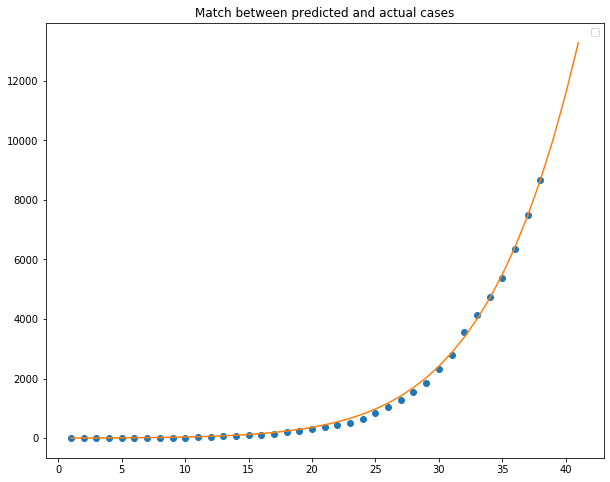

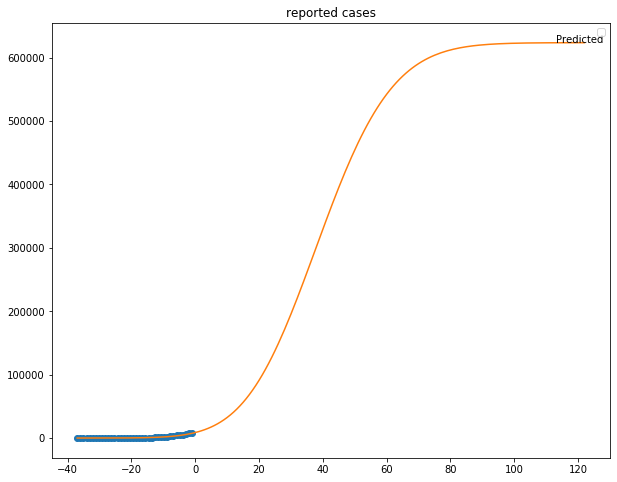

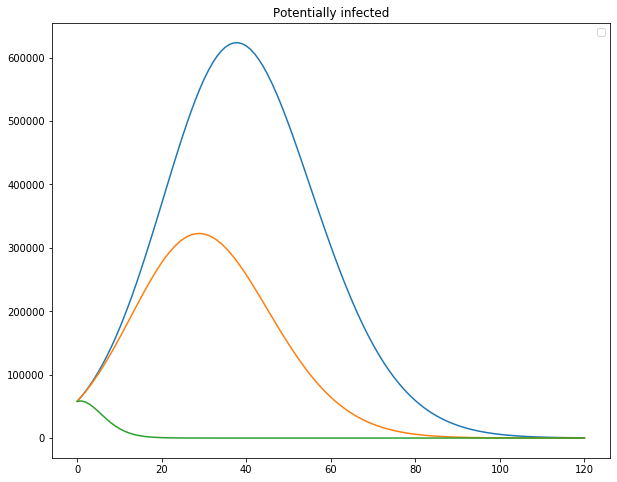

In [478]:
show_match(vals)
present_solution(vals, 160)
prognosis(vals)

In [416]:
def optimize():
    # beta0 = 0.38 #d^{-1}
    # R0 = 3.07
    # alpha0 = R0*beta0
    #k0_0 = 1e-1
    #k_0 = 0.0
    alpha0, beta0, k0_0, k_0, I_0 = vals
    
    alpha = ng.p.Scalar()
    alpha.value = alpha0
    # alpha.value = 0.8921533322357904
    beta = ng.p.Scalar()
    beta.value = beta0
    # beta.value = 0.6006857701497142
    I0 = ng.p.Scalar()
    I0.value = I_0
    # I0.value = 2.0638693642381589e-07
    k0 = ng.p.Scalar()
    k = ng.p.Scalar()
    k0.value = k0_0
    # k0.value = 1e-5
    k.value = k_0
    # k.value = 1e-5
    # k0.value = 0.003774752347706235
    # k.value = 0.018991858675810148
    #k0.set_bounds(0, 5e-2)
    #k.set_bounds(0, 5e-2)
    alpha.set_bounds(0.0, 10.0)
    beta.set_bounds(5e-2, 2.0)
    I0.set_bounds(0.0, 1e-4)
    k0.set_bounds(0, 0.1)
    k.set_bounds(0, 0.1)

    instru = ng.p.Instrumentation(alpha, beta, k0, k, I0)
    #optimizer = ng.optimizers.CMA(parametrization=instru, budget=500000)
    num_workers = 16
    with futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        optimizer = ng.optimizers.CMA(parametrization=instru, budget=20000, num_workers=num_workers) # num_workers don't work :(
        recommendation = optimizer.minimize(loss_fn, executor=executor, batch_mode=False)
    #recommendation = optimizer.minimize(compute_fit)
    return recommendation


    

In [417]:
run_ng_optimize = False
if run_ng_optimize:
    for i in range(30):
        print(f'New round {i+1}')
        recommendation = optimize()
        err = loss_fn(*recommendation.value[0])
        if err < max_err:
            max_err = err
            vals = recommendation.value[0]
            print(f"Error {err}, vals {vals}")
        else:
            print(f"Error too big: {err} > {max_err}")

    print(max_err, vals)
else:
    print("GLOBAL OPTIMIZATION DISABLED: set run_ng_optimize to True to run it")

GLOBAL OPTIMIZATION DISABLED: set run_ng_optimize to True to run it


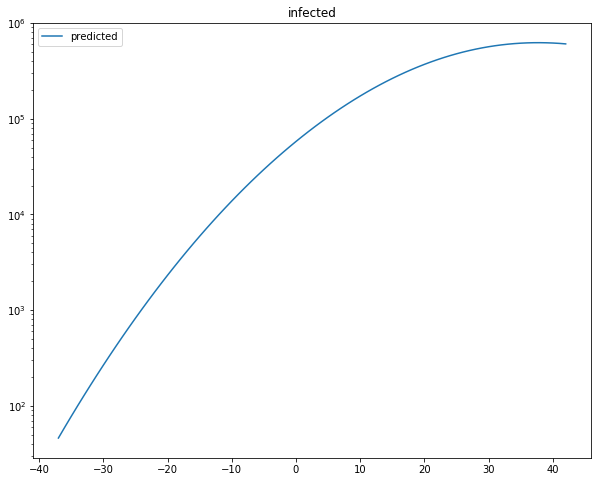

In [451]:
plt.figure(figsize=(10, 8))
alpha_g, beta_g, k0_g, k_g, I0_g = vals
plt.plot(time_scale, population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=80, type_ret=1), "-", label="predicted");
plt.legend();
plt.title('infected');
plt.yscale('log');

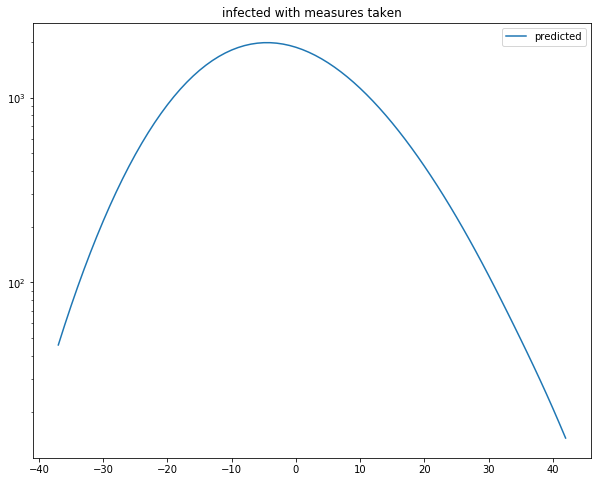

In [452]:
plt.figure(figsize=(10, 8))


plt.plot(time_scale, population[Country]*obs(alpha_g, beta_g, k0_g+1e-2, k_g, I0_g, N=80, type_ret=1), "-", label="predicted");
plt.legend();
plt.title('infected with measures taken');
plt.yscale('log');

In [453]:
good_vals_1 = (0.8921533322357904,
 0.6006857701497142,
 0.003774752347706235,
 0.018991858675810148,
 2.0638693642381589e-07)

good_vals_2 = (1.4620735715158846,
 1.1550524698389562,
 0.00012016896136317736,
 0.09431369871672939,
 8.85266762057214e-08)


In [454]:
print(sorted(ng.optimizers.registry.keys()))

['ASCMA2PDEthird', 'ASCMADEQRthird', 'ASCMADEthird', 'AlmostRotationInvariantDE', 'BO', 'CM', 'CMA', 'CMandAS', 'CMandAS2', 'CMandAS3', 'CauchyLHSSearch', 'CauchyOnePlusOne', 'CauchyScrHammersleySearch', 'Cobyla', 'DE', 'DiagonalCMA', 'DiscreteOnePlusOne', 'DoubleFastGADiscreteOnePlusOne', 'EDA', 'ES', 'FCMA', 'HaltonSearch', 'HaltonSearchPlusMiddlePoint', 'HammersleySearch', 'HammersleySearchPlusMiddlePoint', 'LHSSearch', 'LargeHaltonSearch', 'LhsDE', 'MEDA', 'MPCEDA', 'MetaRecentering', 'MixES', 'MultiCMA', 'MultiScaleCMA', 'MutDE', 'NGO', 'NaiveIsoEMNA', 'NaiveTBPSA', 'NelderMead', 'NoisyBandit', 'NoisyDE', 'NoisyDiscreteOnePlusOne', 'NoisyOnePlusOne', 'ORandomSearch', 'OScrHammersleySearch', 'OnePlusOne', 'OptimisticDiscreteOnePlusOne', 'OptimisticNoisyOnePlusOne', 'PBIL', 'PCEDA', 'PSO', 'ParaPortfolio', 'Portfolio', 'Powell', 'QORandomSearch', 'QOScrHammersleySearch', 'QrDE', 'RCobyla', 'RPowell', 'RSQP', 'RandomSearch', 'RandomSearchPlusMiddlePoint', 'RealSpacePSO', 'RecES', 'Re

Trying to optimize the solution using gradient descent in the small vicinity

In [455]:
bounds = ((0.0, 10.0), (5e-2, 2.0), (0.0, 1e-1), (0, 0.1), (true_cases[0], 1e-6))
bounds_low = np.array([b[0] for b in bounds])
bounds_high = np.array([b[1] for b in bounds])

def cost_fn(x):    
    for v,b in zip(x,bounds):
        l,r = b
        if v < l or v > r:
            return 1e100
    return loss_fn_equal_weight(*x)

In [456]:
from scipy import optimize

In [479]:
# vals2 = optimize.minimize(cost_fn, np.array(vals)+np.array((0.1,0.0,0.0,0.0,0.0)), method='Nelder-Mead')
# bounds = ((0.0, 10.0), (5e-2, 2.0), (0.0, 1e-4), (0, 0.1), (0, 0.1))

# Expect that no more than 1400 people infected when three thirst cases 

#res = optimize.minimize(cost_fn, (bounds_low+bounds_high)/2, method='Nelder-Mead')
res = optimize.minimize(cost_fn, np.array(vals), method='Nelder-Mead')
res.success

True

In [480]:
if res.success:
    vals2 = res.x
else:
    vals2 = vals
vals2, cost_fn(vals2), cost_fn(vals)


(array([6.16232579e-01, 2.98045097e-01, 9.65074918e-03, 4.81589764e-06,
        3.79890775e-07]), 2.699831600178838e-06, 3.6372675835523524e-06)

No handles with labels found to put in legend.


Expected number of cases:1372
Expected number of cases:1543
Expected number of cases:1728


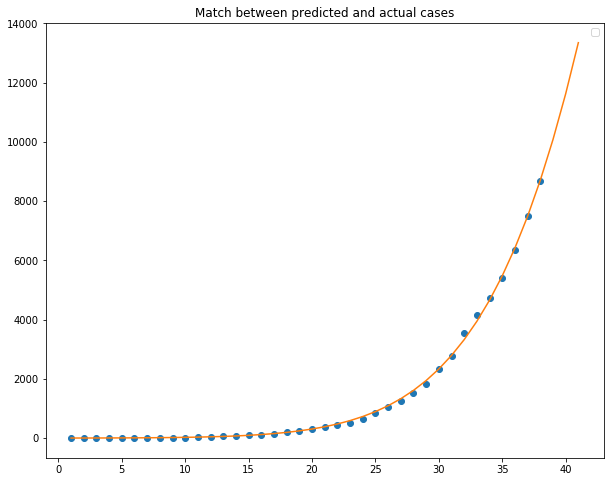

In [481]:
show_match(vals2)

No handles with labels found to put in legend.


Predicted: Max cases: 295435


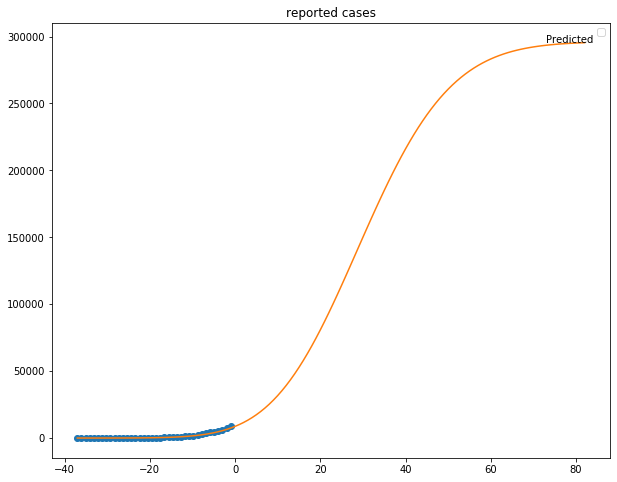

In [482]:
present_solution(vals2, num_days=120)

No handles with labels found to put in legend.


Infected now: 133751
Max infected: 748254 vs 708403 vs 135178


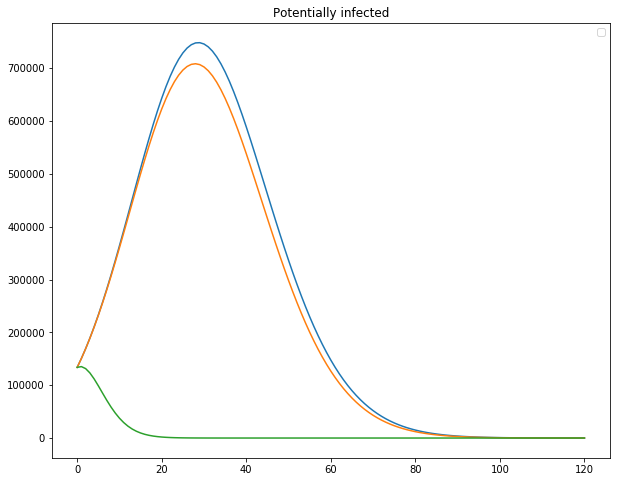

In [483]:
prognosis(vals2)

In [435]:
class VectorIterator:
    def __init__(self, N, low = -1, high = 1):
        self.vector = np.full(N, low)
        self.low = low
        self.high = high
    def __iter__(self):
        self.first = True
        return self
    def __next__(self):
        if self.first:
            self.first = False
            return self.vector
            
        for i,x in enumerate(self.vector):
            if x == self.high:
                self.vector[i] = self.low
            else:
                self.vector[i] += 1
                return self.vector
        raise StopIteration

In [436]:
_local_minimum_factor = 1e-2
def is_local_minimum(fn, x):
    step = x*_local_minimum_factor
    vi = VectorIterator(len(x))
    m = fn(x)
    for v in vi:
        y = x + v*step
        val_y = fn(y)
        if val_y < m:
            return False, (y, val_y)
    return True, None

In [462]:
is_local_minimum(cost_fn, vals2)

(False, (array([6.16232579e-01, 2.98045097e-01, 9.65074918e-03, 4.76773867e-06,
         3.79890775e-07]), 2.699830717049297e-06))

In [484]:
cost_fn(vals2)

2.699831600178838e-06

In [485]:
def simple_descend(start, iters = 2000):
    v = start
    for i in range(iters):
        res, nxt = is_local_minimum(cost_fn, v)
        if res:
            print(f"Local minimum on step {i}")
            break
        else:
            v = nxt[0]
    return v
vals3 = simple_descend(vals2)
print(f"Local minimum {cost_fn(vals3)} at {vals3}")

Local minimum on step 16
Local minimum 2.6998246466795413e-06 at [6.16232579e-01 2.98045097e-01 9.65074918e-03 4.10053347e-06
 3.79890775e-07]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Expected number of cases:1372
Expected number of cases:1543
Expected number of cases:1728
Predicted: Max cases: 295424
Infected now: 133754
Max infected: 748283 vs 708431 vs 135182


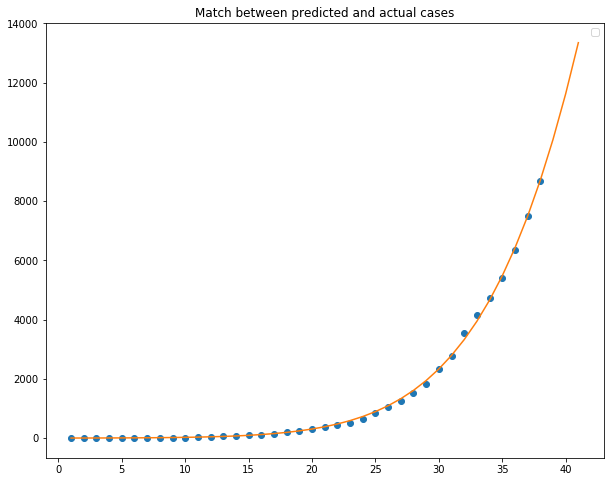

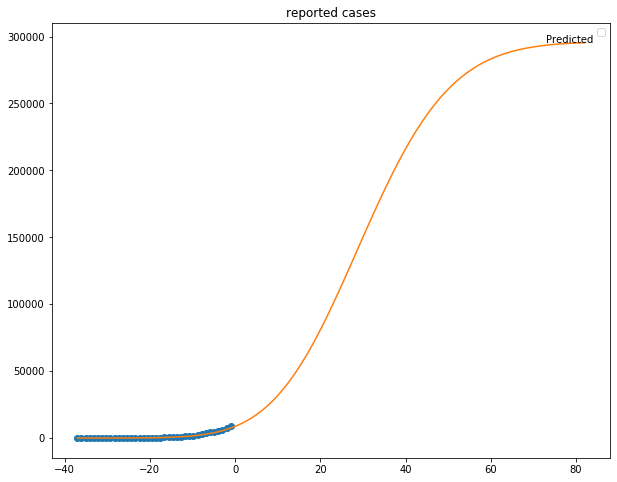

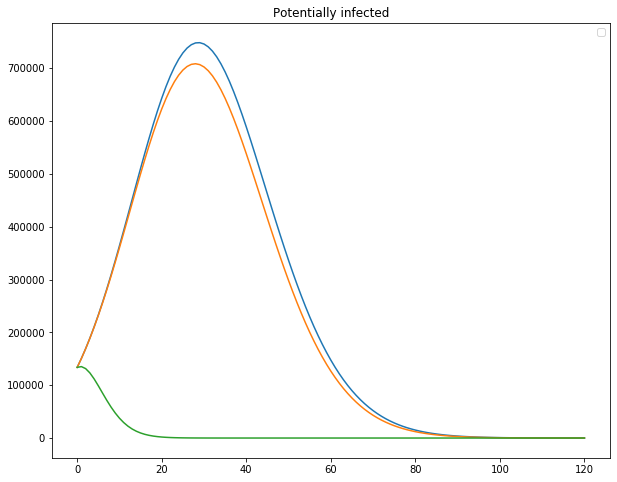

In [486]:
show_match(vals3)
present_solution(vals3, 120)
prognosis(vals3)

In [502]:
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [487]:
import itertools

In [506]:
niter = 1000
random_search_results = []
for i in range(niter):
    if 0 == i%25:
        update_progress(i/niter)
    x = np.random.uniform(bounds_low, bounds_high)
    opt = optimize.minimize(cost_fn, x, method='Nelder-Mead')
    if not opt.success:
        continue
    if opt.fun > 3e-6:
        continue
    # print(f"{i+1}: {opt.fun} at {opt.x}")
    random_search_results.append((i+1, opt.fun, opt.x))
update_progress(1)

Progress: [####################] 100.0%


In [490]:
random_search_results = sorted(random_search_results, key=lambda v: v[1])
best = random_search_results[:10]
best

[(59,
  2.36110366737127e-06,
  array([1.92628554e+00, 1.53149225e+00, 3.92270466e-03, 2.74459522e-02,
         5.37489719e-08])),
 (625,
  2.3616279075834605e-06,
  array([2.03472271e+00, 1.64552965e+00, 3.61144754e-03, 2.64804704e-02,
         5.88330408e-08])),
 (702,
  2.3631499052053775e-06,
  array([1.31963679e+00, 9.51179890e-01, 5.77029964e-03, 8.30720359e-04,
         2.62659846e-07])),
 (295,
  2.3644878578338204e-06,
  array([1.48064996e+00, 1.11810133e+00, 4.89789205e-03, 1.72023309e-03,
         2.77021699e-07])),
 (58,
  2.364934906304663e-06,
  array([1.55519933e+00, 1.17368653e+00, 5.05928632e-03, 6.97545967e-03,
         1.30361580e-07])),
 (999,
  2.3650203352119124e-06,
  array([1.28154179e+00, 8.32704019e-01, 6.83532819e-03, 5.74243335e-02,
         2.10460373e-08])),
 (781,
  2.3658465488181484e-06,
  array([2.03567619e+00, 1.67471641e+00, 3.35742788e-03, 7.66610442e-03,
         1.74650183e-07])),
 (519,
  2.3663273130345733e-06,
  array([6.34977337e-01, 1.7688082

No handles with labels found to put in legend.


1: day 1: number of cases:1378
1: day 2: number of cases:1497
1: day 3: number of cases:1613
2: day 1: number of cases:1381
2: day 2: number of cases:1499
2: day 3: number of cases:1616
3: day 1: number of cases:1371
3: day 2: number of cases:1485
3: day 3: number of cases:1596
4: day 1: number of cases:1365
4: day 2: number of cases:1475
4: day 3: number of cases:1581
5: day 1: number of cases:1361
5: day 2: number of cases:1472
5: day 3: number of cases:1579
6: day 1: number of cases:1374
6: day 2: number of cases:1493
6: day 3: number of cases:1612
7: day 1: number of cases:1357
7: day 2: number of cases:1463
7: day 3: number of cases:1563
8: day 1: number of cases:1401
8: day 2: number of cases:1534
8: day 3: number of cases:1669
9: day 1: number of cases:1380
9: day 2: number of cases:1496
9: day 3: number of cases:1608
10: day 1: number of cases:1354
10: day 2: number of cases:1457
10: day 3: number of cases:1553


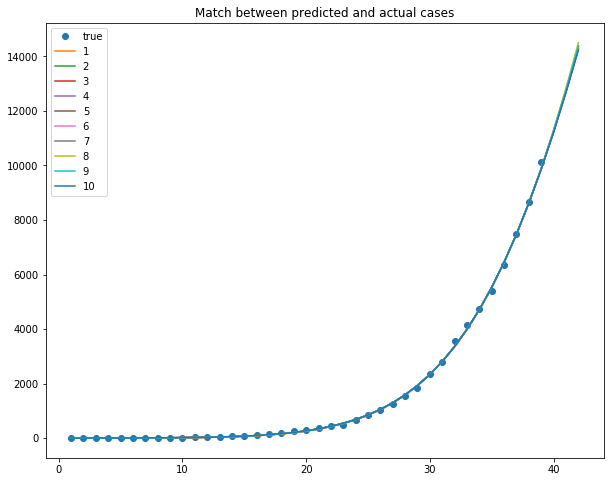

In [495]:
new_figure = True
for i,(_,f,x) in enumerate(best):
    show_match(x, new_figure=new_figure, label=f"{i+1}")
    new_figure = False
plt.legend()
        

No handles with labels found to put in legend.


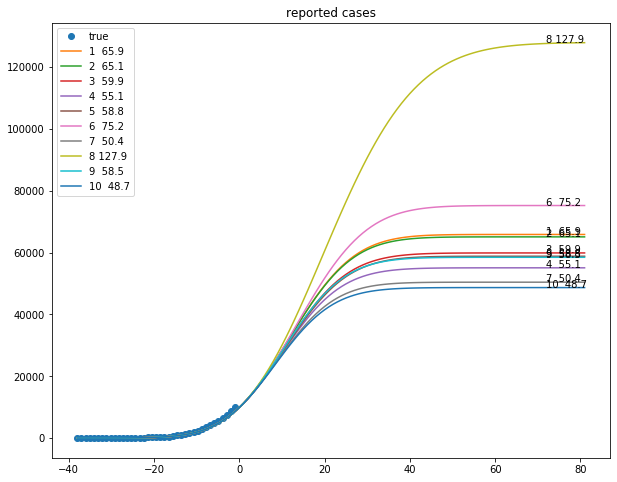

In [510]:
new_figure = True
for i,(_,f,x) in enumerate(best):
    present_solution_many(x, new_figure=new_figure, label_prefix=f"{i+1}")
    new_figure = False
plt.legend()

No handles with labels found to put in legend.


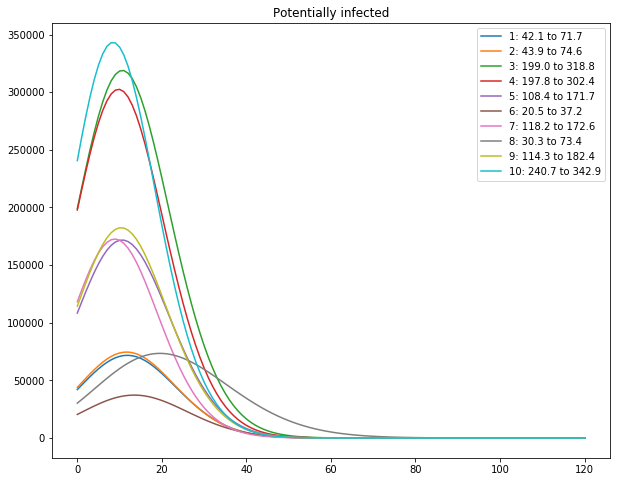

In [500]:
new_figure = True
for i,(_,f,x) in enumerate(best):
    prognosis_many(x, new_figure=new_figure, label_prefix=f"{i+1}")
    new_figure = False
plt.legend()

In [473]:
vals5 = best[0][2]

No handles with labels found to put in legend.


Infected now: 24737
Max infected: 48426 vs 31619 vs 24737


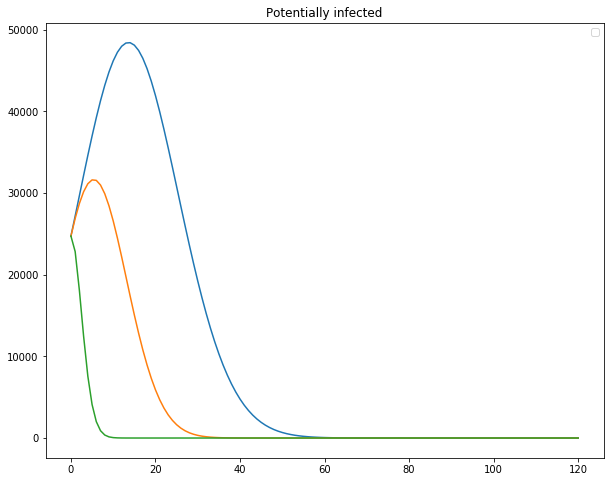

In [474]:
prognosis(vals5)